# Mesh Tutorial 6: Integration with ML Workflows

This tutorial covers advanced topics for using PhysicsNeMo-Mesh in ML pipelines:

1. **Performance Benchmarks**: PhysicsNeMo-Mesh (GPU) vs PyVista/VTK (CPU)
2. **GPU Acceleration Benefits**: When and how much speedup to expect
3. **Batching Meshes**: Padding for torch.compile compatibility
4. **Feature Extraction**: Preparing mesh data for ML models
5. **Boundary Condition Handling**: Storing BC metadata in TensorDict
6. **End-to-End Workflow**: Complete CAE preprocessing example

---

## Why Replace PyVista/VTK in ML Pipelines?

Traditional mesh libraries like PyVista and VTK are excellent tools for visualization and
interactive exploration, but they are fundamentally CPU-bound:

- **CPU-GPU transfers**: Data must be copied to GPU for each training step
- **GIL bottleneck**: Python's Global Interpreter Lock limits parallelism
- **Per-element APIs**: Many operations (e.g., neighbor queries) only expose single-element functions
- **No autograd**: Cannot backpropagate through mesh operations

In large physics-AI training pipelines, mesh preprocessing and ETL can easily become the
bottleneck. When training on millions of mesh samples, even small per-sample overheads compound.

PhysicsNeMo-Mesh addresses these limitations:
- **GPU-native**: All operations are vectorized PyTorch, running natively on CUDA
- **Differentiable**: Seamless integration with PyTorch autograd
- **Batch operations**: Compute neighbors, samples, and features for all elements at once
- **TensorDict-based**: Efficient batching and device management

By moving mesh operations to GPU, we also enable **post-load feature engineering** that would
previously be prohibitively slow - opening opportunities for physics-aware model architectures
that compute geometric features on-the-fly during training.

In [1]:
import platform

import pyvista as pv
import torch
from tensordict import TensorDict

### Benchmark infrastructure and operations (compiled + uncompiled) ###
from benchmarks import (
    benchmark,
    collect_system_metadata,
    compiled_ops,
    plot_speedup_chart,
    raw_ops,
    save_benchmark_results,
)
from physicsnemo.mesh import Mesh
from physicsnemo.mesh.io import from_pyvista, to_pyvista

In [2]:
### System Information

print("=" * 60)
print("SYSTEM INFORMATION")
print("=" * 60)
print(f"Python: {platform.python_version()}")
print(f"PyTorch: {torch.__version__}")
print(f"PyVista: {pv.__version__}")
print(f"CPU: {platform.processor() or platform.machine()}")
print(f"PyTorch CPU threads: {torch.get_num_threads()}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA: {torch.version.cuda}")
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"GPU Memory: {gpu_mem:.1f} GB")
    torch.set_float32_matmul_precision("high")
else:
    print("GPU: Not available (benchmarks will run on CPU only)")
print("=" * 60)

SYSTEM INFORMATION
Python: 3.13.8
PyTorch: 2.10.0+cu130
PyVista: 0.46.5
CPU: x86_64
PyTorch CPU threads: 16
GPU: NVIDIA GeForce RTX 4090 Laptop GPU
CUDA: 13.0
GPU Memory: 17.2 GB


## Section 1: Performance Benchmarks

We compare PhysicsNeMo-Mesh (GPU) to PyVista/VTK (CPU) across several common mesh operations.
All benchmarks use the Stanford Bunny mesh at various subdivision levels. We always use
`to_pyvista(pnm_mesh)` to ensure both libraries operate on identical geometry.

**Operations benchmarked:**
- Normal computation
- Curvature computation
- Subdivision (Loop scheme)
- Neighbor computation (point-to-point, cell-to-cell)
- Random point sampling
- Laplacian smoothing
- Geometric transformations

In [3]:
### Benchmark Configuration ###
# Toggle which variants to include in benchmarks and charts.
# Disable variants to speed up notebook execution.
BENCHMARK_VARIANTS = {
    "pyvista": True,  # PyVista / VTK (CPU baseline)
    "pnm_cpu_raw": True,  # PhysicsNeMo CPU (no torch.compile)
    "pnm_cpu_compiled": True,  # PhysicsNeMo CPU (torch.compile)
    "pnm_gpu_raw": True,  # PhysicsNeMo GPU (no torch.compile)
    "pnm_gpu_compiled": True,  # PhysicsNeMo GPU (torch.compile)
}

In [4]:
# benchmark() and compiled_ops are imported from the benchmarks/ module.
# Store benchmark results for final visualization.
benchmark_results = {}

### Load the Bunny Mesh

We use the Stanford Bunny at increasing subdivision levels to demonstrate scaling behavior.
Higher subdivision levels amortize CUDA kernel launch overhead, showing the true GPU advantage.

In [5]:
# Load the base bunny mesh and create subdivision variants
bunny_base = torch.load("assets/bunny.pt", weights_only=False)

# Create meshes at increasing subdivision levels
# Level 0 = base mesh, Level 3 = highly refined (100k+ cells)
subdivision_levels = [0, 1, 2, 3, 4, 5, 6, 7]
meshes = {}

print("Mesh sizes at each subdivision level:")
print("-" * 50)
for level in subdivision_levels:
    if level == 0:
        meshes[level] = bunny_base.clone()
    else:
        meshes[level] = bunny_base.subdivide(levels=level, filter="loop")
    m = meshes[level]
    print(f"  Level {level}: {m.n_points:,} points, {m.n_cells:,} cells")

Mesh sizes at each subdivision level:
--------------------------------------------------
  Level 0: 400 points, 796 cells
  Level 1: 1,594 points, 3,184 cells
  Level 2: 6,370 points, 12,736 cells
  Level 3: 25,474 points, 50,944 cells
  Level 4: 101,890 points, 203,776 cells
  Level 5: 407,554 points, 815,104 cells
  Level 6: 1,630,210 points, 3,260,416 cells
  Level 7: 6,520,834 points, 13,041,664 cells


### Normal Computation

Computing surface normals is a fundamental operation for rendering, physics simulation, and
ML feature extraction. PyVista calls VTK's CPU-based normal computation; PhysicsNeMo-Mesh
uses vectorized PyTorch operations.

In [6]:
print("Normal Computation Benchmark")
print("=" * 60)

benchmark_results["normals"] = {
    "pyvista": [],
    "pnm_cpu_raw": [],
    "pnm_cpu_compiled": [],
    "pnm_gpu_raw": [],
    "pnm_gpu_compiled": [],
    "sizes": [],
}

for level in subdivision_levels:
    pnm_mesh = meshes[level]
    pv_mesh = to_pyvista(pnm_mesh)
    pts, cls = pnm_mesh.points, pnm_mesh.cells

    print(f"\nLevel {level}: {pnm_mesh.n_points:,} points, {pnm_mesh.n_cells:,} cells")
    benchmark_results["normals"]["sizes"].append(pnm_mesh.n_cells)

    if BENCHMARK_VARIANTS["pyvista"]:
        pv_time, _ = benchmark(
            "  PyVista (CPU)",
            lambda: pv_mesh.compute_normals(cell_normals=True, point_normals=False),
        )
        benchmark_results["normals"]["pyvista"].append(pv_time)

    if BENCHMARK_VARIANTS["pnm_cpu_raw"]:
        t, _ = benchmark("  PNM CPU", lambda: raw_ops.cell_normals(pts, cls))
        benchmark_results["normals"]["pnm_cpu_raw"].append(t)

    if BENCHMARK_VARIANTS["pnm_cpu_compiled"]:
        t, _ = benchmark(
            "  PNM CPU (compiled)", lambda: compiled_ops.cell_normals(pts, cls)
        )
        benchmark_results["normals"]["pnm_cpu_compiled"].append(t)

    if torch.cuda.is_available():
        gpu = pnm_mesh.to("cuda")
        gpts, gcls = gpu.points, gpu.cells

        if BENCHMARK_VARIANTS["pnm_gpu_raw"]:
            t, _ = benchmark("  PNM GPU", lambda: raw_ops.cell_normals(gpts, gcls))
            benchmark_results["normals"]["pnm_gpu_raw"].append(t)

        if BENCHMARK_VARIANTS["pnm_gpu_compiled"]:
            t, _ = benchmark(
                "  PNM GPU (compiled)", lambda: compiled_ops.cell_normals(gpts, gcls)
            )
            benchmark_results["normals"]["pnm_gpu_compiled"].append(t)

Normal Computation Benchmark

Level 0: 400 points, 796 cells
  PyVista (CPU): 0.751 ms (50 runs)
  PNM CPU: 0.573 ms (50 runs)
  PNM CPU (compiled): 0.482 ms (50 runs)
  PNM GPU: 1.463 ms (50 runs)
  PNM GPU (compiled): 1.506 ms (50 runs)

Level 1: 1,594 points, 3,184 cells
  PyVista (CPU): 1.207 ms (50 runs)
  PNM CPU: 0.706 ms (50 runs)
  PNM CPU (compiled): 0.768 ms (50 runs)
  PNM GPU: 1.493 ms (50 runs)
  PNM GPU (compiled): 1.514 ms (50 runs)

Level 2: 6,370 points, 12,736 cells
  PyVista (CPU): 3.105 ms (50 runs)
  PNM CPU: 1.641 ms (50 runs)
  PNM CPU (compiled): 1.484 ms (50 runs)
  PNM GPU: 1.627 ms (50 runs)
  PNM GPU (compiled): 1.764 ms (50 runs)

Level 3: 25,474 points, 50,944 cells
  PyVista (CPU): 10.706 ms (50 runs)
  PNM CPU: 3.770 ms (50 runs)
  PNM CPU (compiled): 6.065 ms (50 runs)
  PNM GPU: 2.314 ms (50 runs)
  PNM GPU (compiled): 1.842 ms (50 runs)

Level 4: 101,890 points, 203,776 cells
  PyVista (CPU): 40.297 ms (50 runs)
  PNM CPU: 9.925 ms (50 runs)
  PNM CP

### Curvature Computation

Gaussian curvature measures local surface bending. This is computed from vertex angles and areas.
PyVista/VTK does not have a direct Gaussian curvature function, so we compare CPU vs GPU within
PhysicsNeMo-Mesh only.

In [7]:
print("Curvature Computation Benchmark")
print("=" * 60)

benchmark_results["curvature"] = {
    "pyvista": [],
    "pnm_cpu_raw": [],
    "pnm_cpu_compiled": [],
    "pnm_gpu_raw": [],
    "pnm_gpu_compiled": [],
    "sizes": [],
}

for level in subdivision_levels[1:]:  # Skip level 0 (too small)
    pnm_mesh = meshes[level]
    pv_mesh = to_pyvista(pnm_mesh)
    pts, cls = pnm_mesh.points, pnm_mesh.cells

    print(f"\nLevel {level}: {pnm_mesh.n_points:,} points")
    benchmark_results["curvature"]["sizes"].append(pnm_mesh.n_points)

    if BENCHMARK_VARIANTS["pyvista"]:
        pv_time, _ = benchmark(
            "  PyVista (CPU)", lambda: pv_mesh.curvature(curv_type="gaussian")
        )
        benchmark_results["curvature"]["pyvista"].append(pv_time)

    if BENCHMARK_VARIANTS["pnm_cpu_raw"]:
        t, _ = benchmark("  PNM CPU", lambda: raw_ops.gaussian_curvature(pts, cls))
        benchmark_results["curvature"]["pnm_cpu_raw"].append(t)

    if BENCHMARK_VARIANTS["pnm_cpu_compiled"]:
        t, _ = benchmark(
            "  PNM CPU (compiled)", lambda: compiled_ops.gaussian_curvature(pts, cls)
        )
        benchmark_results["curvature"]["pnm_cpu_compiled"].append(t)

    if torch.cuda.is_available():
        gpu = pnm_mesh.to("cuda")
        gpts, gcls = gpu.points, gpu.cells

        if BENCHMARK_VARIANTS["pnm_gpu_raw"]:
            t, _ = benchmark(
                "  PNM GPU", lambda: raw_ops.gaussian_curvature(gpts, gcls)
            )
            benchmark_results["curvature"]["pnm_gpu_raw"].append(t)

        if BENCHMARK_VARIANTS["pnm_gpu_compiled"]:
            t, _ = benchmark(
                "  PNM GPU (compiled)",
                lambda: compiled_ops.gaussian_curvature(gpts, gcls),
            )
            benchmark_results["curvature"]["pnm_gpu_compiled"].append(t)

Curvature Computation Benchmark

Level 1: 1,594 points
  PyVista (CPU): 0.502 ms (50 runs)
  PNM CPU: 2.533 ms (50 runs)
  PNM CPU (compiled): 1.130 ms (50 runs)
  PNM GPU: 3.490 ms (50 runs)
  PNM GPU (compiled): 1.448 ms (50 runs)

Level 2: 6,370 points
  PyVista (CPU): 1.448 ms (50 runs)
  PNM CPU: 5.414 ms (50 runs)
  PNM CPU (compiled): 2.233 ms (50 runs)
  PNM GPU: 3.461 ms (50 runs)
  PNM GPU (compiled): 1.635 ms (50 runs)

Level 3: 25,474 points
  PyVista (CPU): 5.243 ms (50 runs)
  PNM CPU: 11.571 ms (50 runs)
  PNM CPU (compiled): 8.950 ms (50 runs)
  PNM GPU: 4.260 ms (50 runs)
  PNM GPU (compiled): 1.963 ms (50 runs)

Level 4: 101,890 points
  PyVista (CPU): 20.708 ms (50 runs)
  PNM CPU: 52.688 ms (33 runs)
  PNM CPU (compiled): 40.498 ms (50 runs)
  PNM GPU: 6.409 ms (50 runs)
  PNM GPU (compiled): 4.331 ms (50 runs)

Level 5: 407,554 points
  PyVista (CPU): 85.403 ms (35 runs)
  PNM CPU: 424.069 ms (7 runs)
  PNM CPU (compiled): 213.721 ms (14 runs)
  PNM GPU: 21.215 ms 

### Gradient Computation

Computing gradients of scalar fields is fundamental for physics simulations and feature extraction.
PyVista provides `compute_derivative()` which wraps VTK's gradient filter. PhysicsNeMo-Mesh offers
both least-squares (LSQ) and discrete exterior calculus (DEC) gradient methods.

In [8]:
print("Gradient Computation Benchmark")
print("=" * 60)

benchmark_results["gradient"] = {
    "pyvista": [],
    "pnm_cpu_raw": [],
    "pnm_cpu_compiled": [],
    "pnm_gpu_raw": [],
    "pnm_gpu_compiled": [],
    "sizes": [],
}

for level in subdivision_levels[
    1:
]:  # Skip level 0 (too small for meaningful gradients)
    pnm_mesh = meshes[level]
    pv_mesh = to_pyvista(pnm_mesh)
    pts, cls = pnm_mesh.points, pnm_mesh.cells

    # Scalar field: z-coordinate
    scalar_field = pts[:, 2].clone()
    pv_mesh.point_data["scalar_field"] = scalar_field.numpy()

    print(f"\nLevel {level}: {pnm_mesh.n_points:,} points")
    benchmark_results["gradient"]["sizes"].append(pnm_mesh.n_points)

    if BENCHMARK_VARIANTS["pyvista"]:
        pv_time, _ = benchmark(
            "  PyVista (CPU)",
            lambda: pv_mesh.compute_derivative(scalars="scalar_field", gradient=True),
        )
        benchmark_results["gradient"]["pyvista"].append(pv_time)

    if BENCHMARK_VARIANTS["pnm_cpu_raw"]:
        t, _ = benchmark(
            "  PNM CPU",
            lambda: raw_ops.gradient(pts, cls, scalar_field),
        )
        benchmark_results["gradient"]["pnm_cpu_raw"].append(t)

    if BENCHMARK_VARIANTS["pnm_cpu_compiled"]:
        t, _ = benchmark(
            "  PNM CPU (compiled)",
            lambda: compiled_ops.gradient(pts, cls, scalar_field),
        )
        benchmark_results["gradient"]["pnm_cpu_compiled"].append(t)

    if torch.cuda.is_available():
        gpu = pnm_mesh.to("cuda")
        gpts, gcls = gpu.points, gpu.cells
        g_scalar = scalar_field.to("cuda")

        if BENCHMARK_VARIANTS["pnm_gpu_raw"]:
            t, _ = benchmark(
                "  PNM GPU",
                lambda: raw_ops.gradient(gpts, gcls, g_scalar),
            )
            benchmark_results["gradient"]["pnm_gpu_raw"].append(t)

        if BENCHMARK_VARIANTS["pnm_gpu_compiled"]:
            t, _ = benchmark(
                "  PNM GPU (compiled)",
                lambda: compiled_ops.gradient(gpts, gcls, g_scalar),
            )
            benchmark_results["gradient"]["pnm_gpu_compiled"].append(t)

Gradient Computation Benchmark

Level 1: 1,594 points
  PyVista (CPU): 2.111 ms (50 runs)
  PNM CPU: 24.839 ms (50 runs)
  PNM CPU (compiled): 23.473 ms (50 runs)
  PNM GPU: 7.729 ms (50 runs)
  PNM GPU (compiled): 7.550 ms (50 runs)

Level 2: 6,370 points
  PyVista (CPU): 7.020 ms (50 runs)
  PNM CPU: 99.287 ms (28 runs)
  PNM CPU (compiled): 104.106 ms (22 runs)
  PNM GPU: 7.535 ms (50 runs)
  PNM GPU (compiled): 7.589 ms (50 runs)

Level 3: 25,474 points
  PyVista (CPU): 26.679 ms (50 runs)
  PNM CPU: 342.779 ms (9 runs)
  PNM CPU (compiled): 343.407 ms (9 runs)
  PNM GPU: 8.224 ms (50 runs)
  PNM GPU (compiled): 8.031 ms (50 runs)

Level 4: 101,890 points
  PyVista (CPU): 112.606 ms (26 runs)
  PNM CPU: 1352.175 ms (3 runs)
  PNM CPU (compiled): 1356.871 ms (3 runs)
  PNM GPU: 9.101 ms (50 runs)
  PNM GPU (compiled): 8.371 ms (50 runs)

Level 5: 407,554 points
  PyVista (CPU): 483.255 ms (6 runs)
  PNM CPU: 6128.439 ms (1 runs)
  PNM CPU (compiled): 5591.905 ms (1 runs)
  PNM GPU: 

### Subdivision

Mesh subdivision increases resolution by splitting each triangle into 4 smaller triangles.
The Loop scheme also smooths the surface. This operation scales with mesh size and is a
common preprocessing step for ML models that require consistent resolution.

In [9]:
print("Subdivision Benchmark (Loop scheme)")
print("=" * 60)

benchmark_results["subdivision"] = {
    "pyvista": [],
    "pnm_cpu_raw": [],
    "pnm_cpu_compiled": [],
    "pnm_gpu_raw": [],
    "pnm_gpu_compiled": [],
    "sizes": [],
}

for level in subdivision_levels[:-1]:  # Subdivide levels 0..N-2 -> 1..N-1
    pnm_mesh = meshes[level]
    pv_mesh = to_pyvista(pnm_mesh)
    pts, cls = pnm_mesh.points, pnm_mesh.cells

    print(f"\nSubdividing level {level} -> {level + 1}")
    print(f"  Input: {pnm_mesh.n_points:,} points, {pnm_mesh.n_cells:,} cells")
    benchmark_results["subdivision"]["sizes"].append(pnm_mesh.n_cells)

    if BENCHMARK_VARIANTS["pyvista"]:
        pv_time, pv_result = benchmark(
            "  PyVista (CPU)", lambda: pv_mesh.subdivide(nsub=1, subfilter="loop")
        )
        benchmark_results["subdivision"]["pyvista"].append(pv_time)
        print(f"    Output: {pv_result.n_points:,} points, {pv_result.n_cells:,} cells")

    if BENCHMARK_VARIANTS["pnm_cpu_raw"]:
        t, _ = benchmark("  PNM CPU", lambda: raw_ops.subdivide(pts, cls))
        benchmark_results["subdivision"]["pnm_cpu_raw"].append(t)

    if BENCHMARK_VARIANTS["pnm_cpu_compiled"]:
        t, _ = benchmark(
            "  PNM CPU (compiled)", lambda: compiled_ops.subdivide(pts, cls)
        )
        benchmark_results["subdivision"]["pnm_cpu_compiled"].append(t)

    if torch.cuda.is_available():
        gpu = pnm_mesh.to("cuda")
        gpts, gcls = gpu.points, gpu.cells

        if BENCHMARK_VARIANTS["pnm_gpu_raw"]:
            t, result = benchmark("  PNM GPU", lambda: raw_ops.subdivide(gpts, gcls))
            benchmark_results["subdivision"]["pnm_gpu_raw"].append(t)

        if BENCHMARK_VARIANTS["pnm_gpu_compiled"]:
            t, result = benchmark(
                "  PNM GPU (compiled)", lambda: compiled_ops.subdivide(gpts, gcls)
            )
            benchmark_results["subdivision"]["pnm_gpu_compiled"].append(t)
            new_pts, new_cls = result
            print(
                f"    Output: {new_pts.shape[0]:,} points, {new_cls.shape[0]:,} cells"
            )

Subdivision Benchmark (Loop scheme)

Subdividing level 0 -> 1
  Input: 400 points, 796 cells
  PyVista (CPU): 1.429 ms (50 runs)
    Output: 1,594 points, 3,184 cells
  PNM CPU: 10.121 ms (50 runs)
  PNM CPU (compiled): 9.942 ms (50 runs)
  PNM GPU: 6.145 ms (50 runs)
  PNM GPU (compiled): 3.844 ms (50 runs)
    Output: 1,594 points, 3,184 cells

Subdividing level 1 -> 2
  Input: 1,594 points, 3,184 cells
  PyVista (CPU): 3.853 ms (50 runs)
    Output: 6,370 points, 12,736 cells
  PNM CPU: 39.854 ms (50 runs)
  PNM CPU (compiled): 53.937 ms (40 runs)
  PNM GPU: 5.179 ms (50 runs)
  PNM GPU (compiled): 4.292 ms (50 runs)
    Output: 6,370 points, 12,736 cells

Subdividing level 2 -> 3
  Input: 6,370 points, 12,736 cells
  PyVista (CPU): 13.158 ms (50 runs)
    Output: 25,474 points, 50,944 cells
  PNM CPU: 181.641 ms (13 runs)
  PNM CPU (compiled): 181.896 ms (14 runs)
  PNM GPU: 5.737 ms (50 runs)
  PNM GPU (compiled): 5.495 ms (50 runs)
    Output: 25,474 points, 50,944 cells

Subdivi

### Neighbor Computation

Finding mesh neighbors (point-to-point, cell-to-cell) is essential for graph neural networks
and message-passing architectures. PyVista/VTK only exposes **per-element** query functions
(`point_neighbors(i)`, `cell_neighbors(i)`), requiring a Python loop over all elements.
PhysicsNeMo-Mesh computes **all neighbors at once** in a single vectorized operation.

This is where the architectural difference is most stark: O(n) Python calls with VTK overhead
vs. a single GPU kernel launch.

In [10]:
print("Neighbor Computation Benchmark")
print("=" * 60)

benchmark_results["neighbors_p2p"] = {
    "pyvista": [],
    "pnm_cpu_raw": [],
    "pnm_cpu_compiled": [],
    "pnm_gpu_raw": [],
    "pnm_gpu_compiled": [],
    "sizes": [],
}
benchmark_results["neighbors_c2c"] = {
    "pyvista": [],
    "pnm_cpu_raw": [],
    "pnm_cpu_compiled": [],
    "pnm_gpu_raw": [],
    "pnm_gpu_compiled": [],
    "sizes": [],
}

neighbor_levels = [
    0,
    1,
    2,
    3,
]  # PyVista's per-element loop is too slow for larger meshes

for level in neighbor_levels:
    pnm_mesh = meshes[level]
    pv_mesh = to_pyvista(pnm_mesh)
    pts, cls = pnm_mesh.points, pnm_mesh.cells

    print(f"\nLevel {level}: {pnm_mesh.n_points:,} points, {pnm_mesh.n_cells:,} cells")
    benchmark_results["neighbors_p2p"]["sizes"].append(pnm_mesh.n_points)
    benchmark_results["neighbors_c2c"]["sizes"].append(pnm_mesh.n_cells)

    ### Point-to-Point Neighbors ###
    print("  Point-to-Point Neighbors:")

    if BENCHMARK_VARIANTS["pyvista"]:
        pv_time, _ = benchmark(
            "    PyVista (CPU loop)",
            lambda: [pv_mesh.point_neighbors(i) for i in range(pv_mesh.n_points)],
        )
        benchmark_results["neighbors_p2p"]["pyvista"].append(pv_time)

    if BENCHMARK_VARIANTS["pnm_cpu_raw"]:
        t, _ = benchmark("    PNM CPU", lambda: raw_ops.p2p_neighbors(pts, cls))
        benchmark_results["neighbors_p2p"]["pnm_cpu_raw"].append(t)

    if BENCHMARK_VARIANTS["pnm_cpu_compiled"]:
        t, _ = benchmark(
            "    PNM CPU (compiled)", lambda: compiled_ops.p2p_neighbors(pts, cls)
        )
        benchmark_results["neighbors_p2p"]["pnm_cpu_compiled"].append(t)

    if torch.cuda.is_available():
        gpu = pnm_mesh.to("cuda")
        gpts, gcls = gpu.points, gpu.cells

        if BENCHMARK_VARIANTS["pnm_gpu_raw"]:
            t, _ = benchmark("    PNM GPU", lambda: raw_ops.p2p_neighbors(gpts, gcls))
            benchmark_results["neighbors_p2p"]["pnm_gpu_raw"].append(t)

        if BENCHMARK_VARIANTS["pnm_gpu_compiled"]:
            t, _ = benchmark(
                "    PNM GPU (compiled)", lambda: compiled_ops.p2p_neighbors(gpts, gcls)
            )
            benchmark_results["neighbors_p2p"]["pnm_gpu_compiled"].append(t)

    ### Cell-to-Cell Neighbors ###
    print("  Cell-to-Cell Neighbors:")

    if BENCHMARK_VARIANTS["pyvista"]:
        pv_time, _ = benchmark(
            "    PyVista (CPU loop)",
            lambda: [
                pv_mesh.cell_neighbors(i, "edges") for i in range(pv_mesh.n_cells)
            ],
        )
        benchmark_results["neighbors_c2c"]["pyvista"].append(pv_time)

    if BENCHMARK_VARIANTS["pnm_cpu_raw"]:
        t, _ = benchmark("    PNM CPU", lambda: raw_ops.c2c_neighbors(pts, cls))
        benchmark_results["neighbors_c2c"]["pnm_cpu_raw"].append(t)

    if BENCHMARK_VARIANTS["pnm_cpu_compiled"]:
        t, _ = benchmark(
            "    PNM CPU (compiled)", lambda: compiled_ops.c2c_neighbors(pts, cls)
        )
        benchmark_results["neighbors_c2c"]["pnm_cpu_compiled"].append(t)

    if torch.cuda.is_available():
        if BENCHMARK_VARIANTS["pnm_gpu_raw"]:
            t, _ = benchmark("    PNM GPU", lambda: raw_ops.c2c_neighbors(gpts, gcls))
            benchmark_results["neighbors_c2c"]["pnm_gpu_raw"].append(t)

        if BENCHMARK_VARIANTS["pnm_gpu_compiled"]:
            t, _ = benchmark(
                "    PNM GPU (compiled)", lambda: compiled_ops.c2c_neighbors(gpts, gcls)
            )
            benchmark_results["neighbors_c2c"]["pnm_gpu_compiled"].append(t)

Neighbor Computation Benchmark

Level 0: 400 points, 796 cells
  Point-to-Point Neighbors:
    PyVista (CPU loop): 70.358 ms (33 runs)
    PNM CPU: 6.767 ms (50 runs)
    PNM CPU (compiled): 8.482 ms (50 runs)
    PNM GPU: 2.241 ms (50 runs)
    PNM GPU (compiled): 1.932 ms (50 runs)
  Cell-to-Cell Neighbors:
    PyVista (CPU loop): 78.453 ms (29 runs)
    PNM CPU: 19.418 ms (50 runs)
    PNM CPU (compiled): 23.178 ms (50 runs)
    PNM GPU: 9.850 ms (50 runs)
    PNM GPU (compiled): 7.708 ms (50 runs)

Level 1: 1,594 points, 3,184 cells
  Point-to-Point Neighbors:
    PyVista (CPU loop): 176.799 ms (16 runs)
    PNM CPU: 20.970 ms (50 runs)
    PNM CPU (compiled): 22.760 ms (50 runs)
    PNM GPU: 1.834 ms (50 runs)
    PNM GPU (compiled): 1.857 ms (50 runs)
  Cell-to-Cell Neighbors:
    PyVista (CPU loop): 240.236 ms (12 runs)
    PNM CPU: 46.727 ms (50 runs)
    PNM CPU (compiled): 38.124 ms (50 runs)
    PNM GPU: 6.097 ms (50 runs)
    PNM GPU (compiled): 8.616 ms (50 runs)

Level 2:

### Random Point Sampling

Sampling random points on mesh surfaces is common for data augmentation, point cloud generation,
and collocation point selection in physics-informed methods. PyVista does not provide a native
surface sampling function - you must manually select cells, compute areas, and generate
barycentric coordinates. PhysicsNeMo-Mesh provides a single vectorized function.

In [11]:
import numpy as np  # needed for PyVista manual sampling below

print("Random Point Sampling Benchmark (area-weighted)")
print("=" * 60)

benchmark_results["sampling"] = {
    "pyvista": [],
    "pnm_cpu_raw": [],
    "pnm_cpu_compiled": [],
    "pnm_gpu_raw": [],
    "pnm_gpu_compiled": [],
    "sizes": [],
}

n_samples = 10000  # Sample this many points

for level in subdivision_levels:
    pnm_mesh = meshes[level]
    pv_mesh = to_pyvista(pnm_mesh)
    pts, cls = pnm_mesh.points, pnm_mesh.cells

    print(f"\nLevel {level}: {pnm_mesh.n_cells:,} cells, sampling {n_samples:,} points")
    benchmark_results["sampling"]["sizes"].append(pnm_mesh.n_cells)

    if BENCHMARK_VARIANTS["pyvista"]:
        # PyVista (CPU) - area-weighted sampling (manual, no native API)
        def pyvista_sample():
            sized = pv_mesh.compute_cell_sizes(length=False, area=True, volume=False)
            areas = sized.cell_data["Area"]
            probs = areas / areas.sum()
            cell_indices = np.random.choice(pv_mesh.n_cells, size=n_samples, p=probs)
            r = np.random.exponential(scale=1.0, size=(n_samples, 3))
            bary = r / r.sum(axis=1, keepdims=True)
            points = []
            for i, cell_idx in enumerate(cell_indices):
                cell = pv_mesh.get_cell(cell_idx)
                verts = np.array([cell.points[j] for j in range(3)])
                points.append(
                    bary[i, 0] * verts[0]
                    + bary[i, 1] * verts[1]
                    + bary[i, 2] * verts[2]
                )
            return np.array(points)

        pv_time, _ = benchmark("  PyVista (CPU manual)", pyvista_sample)
        benchmark_results["sampling"]["pyvista"].append(pv_time)

    if BENCHMARK_VARIANTS["pnm_cpu_raw"]:
        t, _ = benchmark(
            "  PNM CPU",
            lambda: raw_ops.sample_points_area_weighted(pts, cls, n_samples),
        )
        benchmark_results["sampling"]["pnm_cpu_raw"].append(t)

    if BENCHMARK_VARIANTS["pnm_cpu_compiled"]:
        t, _ = benchmark(
            "  PNM CPU (compiled)",
            lambda: compiled_ops.sample_points_area_weighted(pts, cls, n_samples),
        )
        benchmark_results["sampling"]["pnm_cpu_compiled"].append(t)

    if torch.cuda.is_available():
        gpu = pnm_mesh.to("cuda")
        gpts, gcls = gpu.points, gpu.cells

        if BENCHMARK_VARIANTS["pnm_gpu_raw"]:
            t, _ = benchmark(
                "  PNM GPU",
                lambda: raw_ops.sample_points_area_weighted(gpts, gcls, n_samples),
            )
            benchmark_results["sampling"]["pnm_gpu_raw"].append(t)

        if BENCHMARK_VARIANTS["pnm_gpu_compiled"]:
            t, _ = benchmark(
                "  PNM GPU (compiled)",
                lambda: compiled_ops.sample_points_area_weighted(gpts, gcls, n_samples),
            )
            benchmark_results["sampling"]["pnm_gpu_compiled"].append(t)

Random Point Sampling Benchmark (area-weighted)

Level 0: 796 cells, sampling 10,000 points
  PyVista (CPU manual): 361.626 ms (9 runs)
  PNM CPU: 3.149 ms (50 runs)
  PNM CPU (compiled): 1.389 ms (50 runs)
  PNM GPU: 1.531 ms (50 runs)


/home/psharpe/gh/physicsnemo/.venv/lib/python3.13/site-packages/torch/_inductor/compile_fx.py:321: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


  PNM GPU (compiled): 0.585 ms (50 runs)

Level 1: 3,184 cells, sampling 10,000 points
  PyVista (CPU manual): 349.315 ms (9 runs)
  PNM CPU: 4.100 ms (50 runs)
  PNM CPU (compiled): 1.788 ms (50 runs)
  PNM GPU: 1.854 ms (50 runs)
  PNM GPU (compiled): 0.553 ms (50 runs)

Level 2: 12,736 cells, sampling 10,000 points
  PyVista (CPU manual): 359.735 ms (9 runs)
  PNM CPU: 4.480 ms (50 runs)
  PNM CPU (compiled): 2.717 ms (50 runs)
  PNM GPU: 2.091 ms (50 runs)
  PNM GPU (compiled): 0.939 ms (50 runs)

Level 3: 50,944 cells, sampling 10,000 points
  PyVista (CPU manual): 359.745 ms (9 runs)
  PNM CPU: 5.266 ms (50 runs)
  PNM CPU (compiled): 3.569 ms (50 runs)
  PNM GPU: 1.143 ms (50 runs)
  PNM GPU (compiled): 0.556 ms (50 runs)

Level 4: 203,776 cells, sampling 10,000 points
  PyVista (CPU manual): 372.055 ms (8 runs)
  PNM CPU: 9.240 ms (50 runs)
  PNM CPU (compiled): 7.787 ms (50 runs)
  PNM GPU: 1.216 ms (50 runs)
  PNM GPU (compiled): 0.629 ms (50 runs)

Level 5: 815,104 cells, sa

### Laplacian Smoothing

Laplacian smoothing is an iterative mesh smoothing technique that moves each vertex toward
the centroid of its neighbors. Both PyVista and PhysicsNeMo-Mesh provide this operation,
making it a fair direct comparison.

In [12]:
print("Laplacian Smoothing Benchmark")
print("=" * 60)

benchmark_results["smoothing"] = {
    "pyvista": [],
    "pnm_cpu_raw": [],
    "pnm_cpu_compiled": [],
    "pnm_gpu_raw": [],
    "pnm_gpu_compiled": [],
    "sizes": [],
}

n_smooth_iter = 50

for level in subdivision_levels:
    pnm_mesh = meshes[level]
    pv_mesh = to_pyvista(pnm_mesh)
    pts, cls = pnm_mesh.points, pnm_mesh.cells

    print(f"\nLevel {level}: {pnm_mesh.n_points:,} points ({n_smooth_iter} iterations)")
    benchmark_results["smoothing"]["sizes"].append(pnm_mesh.n_points)

    if BENCHMARK_VARIANTS["pyvista"]:
        pv_time, _ = benchmark(
            "  PyVista (CPU)",
            lambda: pv_mesh.smooth(n_iter=n_smooth_iter, relaxation_factor=0.1),
        )
        benchmark_results["smoothing"]["pyvista"].append(pv_time)

    if BENCHMARK_VARIANTS["pnm_cpu_raw"]:
        t, _ = benchmark(
            "  PNM CPU",
            lambda: raw_ops.smooth(pts, cls, n_smooth_iter, 0.1),
        )
        benchmark_results["smoothing"]["pnm_cpu_raw"].append(t)

    if BENCHMARK_VARIANTS["pnm_cpu_compiled"]:
        t, _ = benchmark(
            "  PNM CPU (compiled)",
            lambda: compiled_ops.smooth(pts, cls, n_smooth_iter, 0.1),
        )
        benchmark_results["smoothing"]["pnm_cpu_compiled"].append(t)

    if torch.cuda.is_available():
        gpu = pnm_mesh.to("cuda")
        gpts, gcls = gpu.points, gpu.cells

        if BENCHMARK_VARIANTS["pnm_gpu_raw"]:
            t, _ = benchmark(
                "  PNM GPU",
                lambda: raw_ops.smooth(gpts, gcls, n_smooth_iter, 0.1),
            )
            benchmark_results["smoothing"]["pnm_gpu_raw"].append(t)

        if BENCHMARK_VARIANTS["pnm_gpu_compiled"]:
            t, _ = benchmark(
                "  PNM GPU (compiled)",
                lambda: compiled_ops.smooth(gpts, gcls, n_smooth_iter, 0.1),
            )
            benchmark_results["smoothing"]["pnm_gpu_compiled"].append(t)

Laplacian Smoothing Benchmark

Level 0: 400 points (50 iterations)
  PyVista (CPU): 1.227 ms (50 runs)
  PNM CPU: 21.734 ms (48 runs)
  PNM CPU (compiled): 15.841 ms (50 runs)
  PNM GPU: 32.564 ms (50 runs)
  PNM GPU (compiled): 32.232 ms (50 runs)

Level 1: 1,594 points (50 iterations)
  PyVista (CPU): 2.150 ms (50 runs)
  PNM CPU: 60.009 ms (43 runs)
  PNM CPU (compiled): 62.137 ms (39 runs)
  PNM GPU: 29.785 ms (50 runs)
  PNM GPU (compiled): 33.037 ms (50 runs)

Level 2: 6,370 points (50 iterations)
  PyVista (CPU): 7.538 ms (50 runs)
  PNM CPU: 185.686 ms (14 runs)
  PNM CPU (compiled): 216.789 ms (12 runs)
  PNM GPU: 30.274 ms (50 runs)
  PNM GPU (compiled): 35.483 ms (50 runs)

Level 3: 25,474 points (50 iterations)
  PyVista (CPU): 39.984 ms (50 runs)
  PNM CPU: 691.782 ms (5 runs)
  PNM CPU (compiled): 702.139 ms (5 runs)
  PNM GPU: 33.772 ms (50 runs)
  PNM GPU (compiled): 38.099 ms (50 runs)

Level 4: 101,890 points (50 iterations)
  PyVista (CPU): 248.790 ms (12 runs)
  PNM

### Geometric Transformations

Geometric transformations (translate, rotate, scale) are fundamental operations for data
augmentation and coordinate system manipulation. We benchmark a chain of transformations.

In [13]:
print("Geometric Transformations Benchmark")
print("=" * 60)

benchmark_results["transforms"] = {
    "pyvista": [],
    "pnm_cpu_raw": [],
    "pnm_cpu_compiled": [],
    "pnm_gpu_raw": [],
    "pnm_gpu_compiled": [],
    "sizes": [],
}

# Pre-compute transform parameters (shared across all levels)
offset_cpu = torch.tensor([1.0, 2.0, 3.0])
angle_x = torch.tensor(torch.pi / 4)  # 45 degrees
angle_y = torch.tensor(torch.pi / 6)  # 30 degrees

for level in subdivision_levels:
    pnm_mesh = meshes[level]
    pv_mesh = to_pyvista(pnm_mesh)
    pts, cls = pnm_mesh.points, pnm_mesh.cells

    print(f"\nLevel {level}: {pnm_mesh.n_points:,} points")
    benchmark_results["transforms"]["sizes"].append(pnm_mesh.n_points)

    if BENCHMARK_VARIANTS["pyvista"]:

        def pyvista_transform():
            result = pv_mesh.translate((1.0, 2.0, 3.0), inplace=False)
            result = result.rotate_x(45, inplace=False)
            result = result.rotate_y(30, inplace=False)
            result = result.scale((2.0, 2.0, 2.0), inplace=False)
            return result

        pv_time, _ = benchmark("  PyVista (CPU)", pyvista_transform)
        benchmark_results["transforms"]["pyvista"].append(pv_time)

    if BENCHMARK_VARIANTS["pnm_cpu_raw"]:
        t, _ = benchmark(
            "  PNM CPU",
            lambda: raw_ops.transforms(pts, cls, offset_cpu, angle_x, angle_y, 2.0),
        )
        benchmark_results["transforms"]["pnm_cpu_raw"].append(t)

    if BENCHMARK_VARIANTS["pnm_cpu_compiled"]:
        t, _ = benchmark(
            "  PNM CPU (compiled)",
            lambda: compiled_ops.transforms(
                pts, cls, offset_cpu, angle_x, angle_y, 2.0
            ),
        )
        benchmark_results["transforms"]["pnm_cpu_compiled"].append(t)

    if torch.cuda.is_available():
        gpu = pnm_mesh.to("cuda")
        gpts, gcls = gpu.points, gpu.cells
        offset_gpu = offset_cpu.to("cuda")

        if BENCHMARK_VARIANTS["pnm_gpu_raw"]:
            t, _ = benchmark(
                "  PNM GPU",
                lambda: raw_ops.transforms(
                    gpts, gcls, offset_gpu, angle_x, angle_y, 2.0
                ),
            )
            benchmark_results["transforms"]["pnm_gpu_raw"].append(t)

        if BENCHMARK_VARIANTS["pnm_gpu_compiled"]:
            t, _ = benchmark(
                "  PNM GPU (compiled)",
                lambda: compiled_ops.transforms(
                    gpts, gcls, offset_gpu, angle_x, angle_y, 2.0
                ),
            )
            benchmark_results["transforms"]["pnm_gpu_compiled"].append(t)

Geometric Transformations Benchmark

Level 0: 400 points
  PyVista (CPU): 3.754 ms (50 runs)
  PNM CPU: 0.629 ms (50 runs)
  PNM CPU (compiled): 0.562 ms (50 runs)
  PNM GPU: 2.791 ms (50 runs)
  PNM GPU (compiled): 1.869 ms (50 runs)

Level 1: 1,594 points
  PyVista (CPU): 3.423 ms (50 runs)
  PNM CPU: 0.574 ms (50 runs)
  PNM CPU (compiled): 0.711 ms (50 runs)
  PNM GPU: 2.919 ms (50 runs)
  PNM GPU (compiled): 3.960 ms (50 runs)

Level 2: 6,370 points
  PyVista (CPU): 3.611 ms (50 runs)
  PNM CPU: 0.624 ms (50 runs)
  PNM CPU (compiled): 0.838 ms (50 runs)
  PNM GPU: 2.891 ms (50 runs)
  PNM GPU (compiled): 1.828 ms (50 runs)

Level 3: 25,474 points
  PyVista (CPU): 4.352 ms (50 runs)
  PNM CPU: 0.751 ms (50 runs)
  PNM CPU (compiled): 1.220 ms (50 runs)
  PNM GPU: 2.861 ms (50 runs)
  PNM GPU (compiled): 1.896 ms (50 runs)

Level 4: 101,890 points
  PyVista (CPU): 7.568 ms (50 runs)
  PNM CPU: 0.876 ms (50 runs)
  PNM CPU (compiled): 2.338 ms (50 runs)
  PNM GPU: 2.861 ms (50 runs)

### Saving Benchmark Results

The `benchmarks/` module provides `save_benchmark_results()` and `load_benchmark_results()`
for persisting results to JSON. Each file captures system metadata, benchmark configuration,
and all timing data - enabling comparisons across hardware (CPU, 4090, H100, B200) and
mesh sizes (small vs. large).

In [14]:
### Save benchmark results to disk ###
metadata = collect_system_metadata()

# Derive a short GPU identifier for the filename
gpu_short = metadata["gpu"].split()[-2].lower() if metadata["gpu"] else "cpu_only"
results_path = save_benchmark_results(
    results=benchmark_results,
    metadata=metadata,
    config={"mesh_bucket": "small", "mesh_source": "Stanford Bunny"},
    path=f"benchmark_{gpu_short}_small.json",
)

Benchmark results saved to benchmark_laptop_small.json


In [15]:
# (Results saved in the cell above.)

### Benchmark Summary

We show the speedup of each PhysicsNeMo-Mesh variant over PyVista (CPU) for the largest
mesh size tested in each category. Comparing raw vs. compiled bars reveals the effect of
`torch.compile`, while comparing CPU vs. GPU bars reveals the hardware acceleration benefit.


Benchmark visualization saved to benchmark_results.png


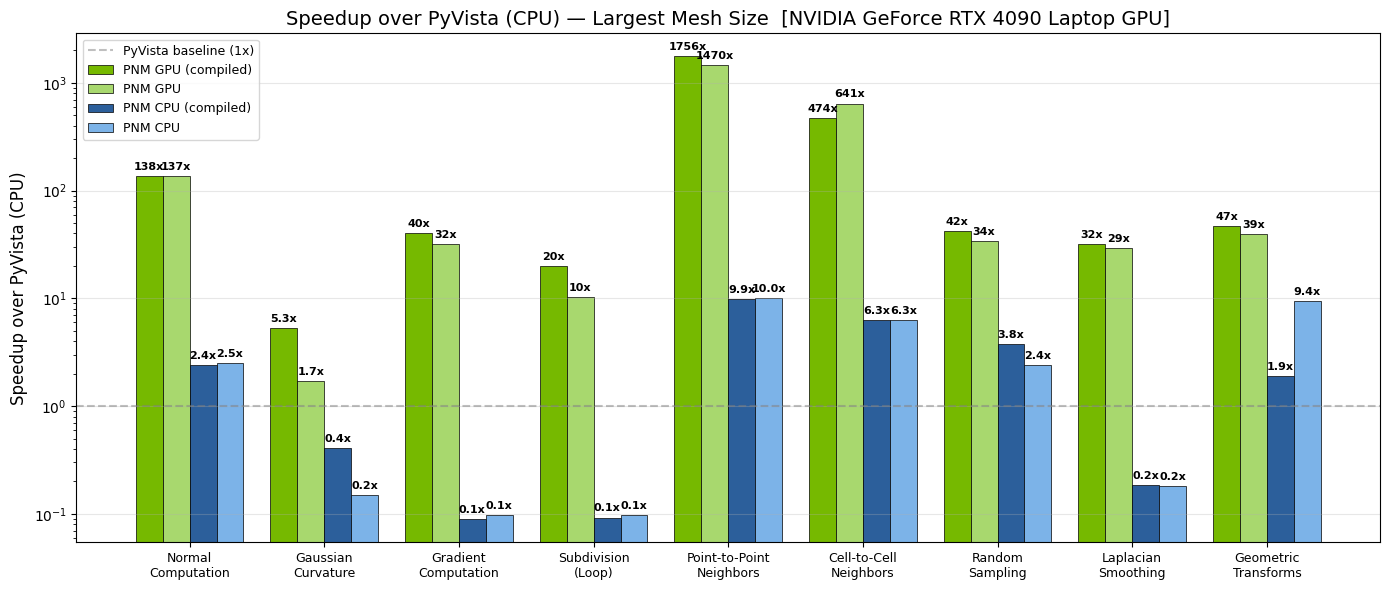

In [16]:
### Plot speedup chart from live benchmark results ###
gpu_name = metadata.get("gpu", "") if metadata else ""
plot_speedup_chart(
    results=benchmark_results,
    title_suffix=gpu_name,
    save_path="benchmark_results.png",
)

### Key Takeaways

The benchmarks demonstrate several important points:

1. **Neighbor computation shows the largest speedups** - This is because PyVista/VTK only
   exposes per-element query functions, requiring O(n) Python calls with VTK overhead.
   PhysicsNeMo-Mesh computes all neighbors in a single vectorized GPU operation.

2. **Speedups increase with mesh size** - Larger meshes better amortize CUDA kernel launch
   overhead, showing the true GPU advantage for production workloads.

3. **Batch operations are key** - Operations like random sampling, where PyVista requires
   manual Python loops, show dramatic speedups when vectorized on GPU.

4. **Even simple operations benefit** - Normal computation and transformations, while fast
   on CPU, still see meaningful speedups on GPU - and these add up in training loops.

**For physics-AI pipelines**: When training on millions of mesh samples, even 10x speedups
in preprocessing translate to significant time and cost savings. More importantly, having
mesh operations on GPU enables:

- **On-the-fly feature engineering**: Compute geometric features during training, not just preprocessing
- **Differentiable mesh operations**: Backpropagate through mesh computations for end-to-end learning
- **Dynamic augmentation**: Apply random transformations without CPU-GPU transfer overhead

## Section 2: Batching Meshes for Training

When training with meshes of varying sizes, you need to handle dynamic shapes.
PhysicsNeMo-Mesh provides padding utilities for this.

In [17]:
# Use the bunny meshes at different subdivision levels (already created above)
batching_meshes = [meshes[0], meshes[1], meshes[2]]

print("Original mesh sizes:")
for i, m in enumerate(batching_meshes):
    print(f"  Mesh {i}: {m.n_points:,} points, {m.n_cells:,} cells")

Original mesh sizes:
  Mesh 0: 400 points, 796 cells
  Mesh 1: 1,594 points, 3,184 cells
  Mesh 2: 6,370 points, 12,736 cells


### Fixed-Size Padding

In [18]:
# Pad all meshes to fixed sizes
max_points = max(m.n_points for m in batching_meshes)
max_cells = max(m.n_cells for m in batching_meshes)

padded_meshes = [
    m.pad(target_n_points=max_points, target_n_cells=max_cells) for m in batching_meshes
]

print(f"\nPadded to {max_points:,} points, {max_cells:,} cells:")
for i, m in enumerate(padded_meshes):
    print(f"  Mesh {i}: {m.n_points:,} points, {m.n_cells:,} cells")


Padded to 6,370 points, 12,736 cells:
  Mesh 0: 6,370 points, 12,736 cells
  Mesh 1: 6,370 points, 12,736 cells
  Mesh 2: 6,370 points, 12,736 cells


### Power-Based Padding (for torch.compile)

For `torch.compile` with `dynamic=False`, pad to the next power of a base.
This limits the number of compiled kernel variants.

In [19]:
# Pad to next power of 1.5 (balances memory vs. compile cache hits)
power_padded = [m.pad_to_next_power(power=1.5) for m in batching_meshes]

print("Power-padded sizes:")
for i, (orig, padded) in enumerate(zip(batching_meshes, power_padded)):
    print(
        f"  Mesh {i}: {orig.n_points:,} -> {padded.n_points:,} points, "
        f"{orig.n_cells:,} -> {padded.n_cells:,} cells"
    )

Power-padded sizes:
  Mesh 0: 400 -> 437 points, 796 -> 985 cells
  Mesh 1: 1,594 -> 2,216 points, 3,184 -> 3,325 cells
  Mesh 2: 6,370 -> 7,481 points, 12,736 -> 16,834 cells


## Section 3: Feature Extraction for ML

Prepare geometric and physical features for model input.

In [20]:
def extract_features(mesh):
    """Extract features for an ML model."""
    features = TensorDict({}, batch_size=[mesh.n_points])

    # Geometric features
    features["position"] = mesh.points

    if mesh.codimension == 1:  # Surface mesh
        features["normal"] = mesh.point_normals
        features["gaussian_curvature"] = mesh.gaussian_curvature_vertices.unsqueeze(-1)
        features["mean_curvature"] = mesh.mean_curvature_vertices.unsqueeze(-1)

    return features

In [21]:
# Example: extract features from bunny mesh
bunny = torch.load("assets/bunny.pt", weights_only=False).subdivide(2, "loop")

features = extract_features(bunny)

print("Extracted features:")
for key in features.keys():
    print(f"  {key}: {features[key].shape}")

Extracted features:
  position: torch.Size([6370, 3])
  normal: torch.Size([6370, 3])
  gaussian_curvature: torch.Size([6370, 1])
  mean_curvature: torch.Size([6370, 1])


In [22]:
# Concatenate into feature matrix
feature_matrix = torch.cat(
    [
        features["position"],
        features["normal"],
        features["gaussian_curvature"],
        features["mean_curvature"],
    ],
    dim=-1,
)

print(f"Feature matrix: {feature_matrix.shape}")
print(f"  (n_points, n_features)")

Feature matrix: torch.Size([6370, 8])
  (n_points, n_features)


## Section 4: Boundary Condition Handling

A key advantage of PhysicsNeMo-Mesh is the ability to store rich metadata,
including boundary condition information.

In [23]:
# Example: CFD mesh with boundary conditions (using bunny mesh)
bc_mesh = meshes[2].clone()  # Use level 2 bunny

# Define BC types
BC_INTERIOR = 0
BC_INLET = 1
BC_OUTLET = 2
BC_WALL = 3

# Assign BC types based on position (example)
# Bunny is roughly centered, so we use quantiles to define boundaries
x = bc_mesh.points[:, 0]
x_min, x_max = x.min(), x.max()
x_range = x_max - x_min

bc_type = torch.full((bc_mesh.n_points,), BC_INTERIOR, dtype=torch.long)
bc_type[x < x_min + 0.15 * x_range] = BC_INLET
bc_type[x > x_max - 0.15 * x_range] = BC_OUTLET
bc_type[
    (x >= x_min + 0.15 * x_range)
    & (x <= x_max - 0.15 * x_range)
    & (bc_mesh.points[:, 2] < bc_mesh.points[:, 2].median())
] = BC_WALL

bc_mesh.point_data["bc_type"] = bc_type

print("Boundary condition counts:")
for name, val in [("Interior", 0), ("Inlet", 1), ("Outlet", 2), ("Wall", 3)]:
    count = (bc_type == val).sum().item()
    print(f"  {name}: {count}")

Boundary condition counts:
  Interior: 2651
  Inlet: 138
  Outlet: 1102
  Wall: 2479


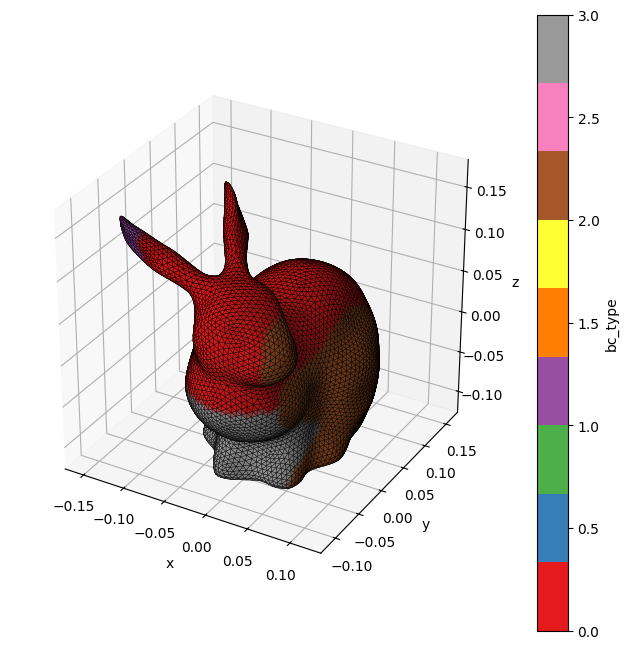

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [24]:
# Visualize BC types
bc_mesh.draw(point_scalars="bc_type", cmap="Set1", backend="matplotlib")

In [25]:
# Store BC values in nested TensorDict
bc_mesh.point_data["bc_values"] = TensorDict(
    {
        "velocity": torch.zeros(bc_mesh.n_points, 3),
        "pressure": torch.full((bc_mesh.n_points,), float("nan")),
    },
    batch_size=[bc_mesh.n_points],
)

# Set inlet velocity (1 m/s in x-direction)
inlet_mask = bc_mesh.point_data["bc_type"] == BC_INLET
bc_mesh.point_data["bc_values", "velocity"][inlet_mask] = torch.tensor([1.0, 0.0, 0.0])

# Set outlet pressure (0 Pa gauge)
outlet_mask = bc_mesh.point_data["bc_type"] == BC_OUTLET
bc_mesh.point_data["bc_values", "pressure"][outlet_mask] = 0.0

print(f"Mesh with BCs: {bc_mesh}")

Mesh with BCs: Mesh(manifold_dim=2, spatial_dim=3, n_points=6370, n_cells=12736)
    point_data : {
        bc_type  : (),
        bc_values: {pressure: (), velocity: (3,)}}
    cell_data  : {}
    global_data: {}


## Section 5: End-to-End CAE Workflow

Complete example: load mesh, extract features, prepare for GNN training.

In [26]:
def prepare_mesh_for_training(mesh, device="cpu"):
    """
    Prepare a mesh for GNN training.

    Returns:
        node_features: (n_nodes, n_features)
        edge_index: (2, n_edges)
        edge_features: (n_edges, n_edge_features)
    """
    mesh = mesh.to(device)

    ### Node features: position + geometric features
    node_features = [mesh.points]

    if mesh.codimension == 1:
        node_features.append(mesh.point_normals)
        node_features.append(mesh.gaussian_curvature_vertices.unsqueeze(-1))
        node_features.append(mesh.mean_curvature_vertices.unsqueeze(-1))

    node_features = torch.cat(node_features, dim=-1)

    ### Edge index from mesh adjacency
    adj = mesh.get_point_to_points_adjacency()
    neighbor_counts = adj.offsets[1:] - adj.offsets[:-1]
    source = torch.repeat_interleave(
        torch.arange(mesh.n_points, device=device), neighbor_counts
    )
    target = adj.indices
    edge_index = torch.stack([source, target], dim=0)

    ### Edge features: relative position, distance
    edge_vectors = mesh.points[target] - mesh.points[source]
    edge_lengths = edge_vectors.norm(dim=-1, keepdim=True)
    edge_features = torch.cat([edge_vectors, edge_lengths], dim=-1)

    return {
        "node_features": node_features,
        "edge_index": edge_index,
        "edge_features": edge_features,
        "n_nodes": mesh.n_points,
        "n_edges": edge_index.shape[1],
    }

In [27]:
# Example usage
bunny = torch.load("assets/bunny.pt", weights_only=False).subdivide(2, "loop")

device = "cuda" if torch.cuda.is_available() else "cpu"
graph_data = prepare_mesh_for_training(bunny, device=device)

print("GNN-ready data:")
for key, value in graph_data.items():
    if isinstance(value, torch.Tensor):
        print(f"  {key}: {value.shape} on {value.device}")
    else:
        print(f"  {key}: {value}")

GNN-ready data:
  node_features: torch.Size([6370, 8]) on cuda:0
  edge_index: torch.Size([2, 38208]) on cuda:0
  edge_features: torch.Size([38208, 4]) on cuda:0
  n_nodes: 6370
  n_edges: 38208


## Section 6: torch.compile Compatibility

Most PhysicsNeMo-Mesh operations are compatible with `torch.compile`.

In [28]:
if torch.cuda.is_available():

    @torch.compile
    def compute_features_compiled(points, cells):
        """Compiled feature computation."""
        m = Mesh(points=points, cells=cells)
        normals = m.cell_normals
        areas = m.cell_areas
        return normals, areas

    # Use the bunny mesh on GPU
    compile_mesh = meshes[2].to("cuda")  # Level 2 bunny

    print("Testing torch.compile...")
    normals, areas = compute_features_compiled(compile_mesh.points, compile_mesh.cells)
    print(f"  Normals: {normals.shape}")
    print(f"  Areas: {areas.shape}")
    print("  Success!")
else:
    print("CUDA not available - skipping torch.compile demo")

Testing torch.compile...
  Normals: torch.Size([12736, 3])
  Areas: torch.Size([12736])
  Success!


## Summary

In this tutorial, you learned about ML integration:

1. **Performance Benchmarks**: Comprehensive comparison of PhysicsNeMo-Mesh (GPU) vs PyVista/VTK (CPU)
   - Normal computation, curvature, subdivision, neighbor queries
   - Random sampling, Laplacian smoothing, geometric transformations
   - Neighbor computation shows the largest speedups due to vectorized vs per-element APIs
2. **Batching**: `pad()` and `pad_to_next_power()` for dynamic shapes with torch.compile
3. **Feature Extraction**: Geometric features (normals, curvature) for model input
4. **Boundary Conditions**: Nested TensorDict for rich metadata storage
5. **End-to-End**: Complete workflow from mesh to GNN-ready data
6. **torch.compile**: Most operations are compilation-compatible

---

### Key Takeaway

PyVista and VTK are excellent tools for visualization and interactive exploration. However,
for large-scale physics-AI training pipelines, their CPU-bound nature and per-element APIs
create bottlenecks. PhysicsNeMo-Mesh addresses this by providing:

- **Vectorized GPU operations**: Compute all neighbors, samples, or features in one kernel
- **Differentiable mesh processing**: Enable end-to-end learning through mesh operations
- **On-the-fly feature engineering**: Compute geometric features during training, not just preprocessing

This enables new physics-aware model architectures that were previously impractical.

---

### Conclusion

You've completed the PhysicsNeMo-Mesh tutorial series! You now know how to:

- Create, load, and manipulate meshes
- Perform geometric transformations and subdivision
- Compute gradients, divergence, curl, and curvature
- Query neighbors and perform spatial searches
- Validate and repair meshes
- Integrate meshes into high-performance ML training pipelines

For more details, see the [physicsnemo.mesh README](../../../physicsnemo/mesh/README.md).